# Getting Started with OpenQASM on Braket

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

OpenQASM is a popular human-readable and hardware-agnostic quantum circuit description language. It is open-source and has been actively maintained by a [Technical Steering Committee](https://medium.com/qiskit/introducing-a-technical-steering-committee-for-openqasm3-f9db808108e1) formed by IBM, Amazon, Microsoft and the University of Innsbruck. Amazon Braket now supports OpenQASM 3.0 as an *Intermediate Representation* (IR) in addition to the in-house *JSON-Based AWS Quantum Circuit Description* ([JAQCD](https://github.com/amazon-braket/amazon-braket-schemas-python/tree/main/src/braket/ir/jaqcd)). In this notebook, we demonstrate how to submit OpenQASM quantum tasks to various devices on Braket and introduce some OpenQASM features available on Braket.

## Create and submit an OpenQASM quantum task

Submitting a quantum task with OpenQASM is just as simple as using JAQCD. You can use the Amazon Braket Python SDK, Boto3, or the AWS CLI to submit OpenQASM 3.0 quantum tasks to an Amazon Braket device. We will go over each method in this section.


### A Bell state

We will start with by preparing a [Bell state](https://en.wikipedia.org/wiki/Bell_state) in OpenQASM:


In [2]:
bell_qasm = """
OPENQASM 3;

qubit[2] q;
bit[2] c;

h q[0];
cnot q[0], q[1];

c = measure q;
"""

Compare this to the same Bell state written in JAQCD:

In [3]:
from braket.ir.jaqcd import CNot, H, Program

program = Program(instructions=[H(target=0), CNot(control=0, target=1)])
print(program.json(indent=2))

{
  "braketSchemaHeader": {
    "name": "braket.ir.jaqcd.program",
    "version": "1"
  },
  "instructions": [
    {
      "target": 0,
      "type": "h"
    },
    {
      "control": 0,
      "target": 1,
      "type": "cnot"
    }
  ],
  "results": null,
  "basis_rotation_instructions": null
}


Immediately, we can see a difference: In OpenQASM, users define their own qubit registers, and thus the syntax is closer to what quantum algorithm researchers are used to; on the other hand, in JAQCD, qubits are indexed by integers and the convention is closer to that of hardware providers. Also, JAQCD has result types and basis rotation instructions embedded in the language while OpenQASM doesn't support them inherently (but later we will show how to use the `pragma` syntax to support them in OpenQASM).


### Use the Python SDK to create OpenQASM 3.0 quantum tasks

Most Braket users might want to use the Braket Python SDK to submit OpenQASM quantum tasks. To submit our Bell state program in the Python SDK, we first choose the quantum device that we want to run our  program on. In this example, we will use the SV1 state-vector simulator for demonstration.

In [4]:
from braket.aws import AwsDevice
from braket.devices import Devices
sv1 = AwsDevice(Devices.Amazon.SV1)

To submit the OpenQASM quantum task, we initialize an `OpenQASMProgram` object using the Bell state program text string `bell_qasm` we defined above and send it to the SV1 simulator.

In [5]:
from braket.ir.openqasm import Program as OpenQASMProgram

bell_program = OpenQASMProgram(source=bell_qasm)
bell_task = sv1.run(
    bell_program, 
    shots=100, 
)

###  Submit OpenQASM 3.0 programs using the AWS Command Line Interface

Alternatively, if you like the command line experience or you are not a Python user, you can also choose to use the [AWS Command Line Interface (CLI)](https://aws.amazon.com/cli/) to submit our Bell state program. Before doing that we have to make sure we have [AWS CLI installed](https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html). The following code saves the `bell_qasm` string to a file named `bell.qasm`:

In [6]:
with open("bell.qasm", "w") as f:
    f.write(bell_qasm)

Then we can use the command below to submit the quantum task via AWS CLI. Remember to replace the placeholder \"amazon-braket-my-bucket\" with your own bucket name.
      
    aws braket create-quantum-task \
    --region "us-west-1" \
    --device-arn "arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-2" \
    --shots 100 \
    --action '{
        "braketSchemaHeader": {
            "name": "braket.ir.openqasm.program", 
            "version": "1"
        },
        "source": $(cat bell.qasm)
    }'

## Convert OpenQASM 3.0 programs to circuits

You can convert OpenQASM programs into Braket `Circuit` objects if you want to programmatically change your program.

In [7]:
from braket.circuits import Circuit
print(Circuit.from_ir(bell_qasm))

T  : │  0  │  1  │  2  │
      ┌───┐       ┌───┐ 
q0 : ─┤ H ├───●───┤ M ├─
      └───┘   │   └───┘ 
            ┌─┴─┐ ┌───┐ 
q1 : ───────┤ X ├─┤ M ├─
            └───┘ └───┘ 
T  : │  0  │  1  │  2  │


## Figure out what OpenQASM features are supported on each device

Different devices on Braket support different subsets of OpenQASM features. To see what are the supported OpenQASM features on each device, we can simply check the device capability for OpenQASM actions. As an example, we can take a look at the `action` field in the device capability of SV1 simulator:

In [8]:
# supportedOperations
sv1.properties.action['braket.ir.openqasm.program'].supportedOperations

['ccnot',
 'cnot',
 'cphaseshift',
 'cphaseshift00',
 'cphaseshift01',
 'cphaseshift10',
 'cswap',
 'cy',
 'cz',
 'ecr',
 'h',
 'i',
 'iswap',
 'pswap',
 'phaseshift',
 'rx',
 'ry',
 'rz',
 's',
 'si',
 'swap',
 't',
 'ti',
 'v',
 'vi',
 'x',
 'xx',
 'xy',
 'y',
 'yy',
 'z',
 'zz',
 'gpi',
 'gpi2',
 'ms']

In [9]:
# supportedPragmas
sv1.properties.action['braket.ir.openqasm.program'].supportedPragmas

['braket_unitary_matrix',
 'braket_basis_rotation',
 'braket_result_type_sample',
 'braket_result_type_expectation',
 'braket_result_type_variance',
 'braket_result_type_probability',
 'braket_result_type_amplitude',
 'braket_result_type_adjoint_gradient']

In [10]:
# forbiddenPragmas
sv1.properties.action['braket.ir.openqasm.program'].forbiddenPragmas

['braket_result_type_state_vector',
 'braket_result_type_density_matrix',
 'braket_noise_amplitude_damping',
 'braket_noise_bit_flip',
 'braket_noise_depolarizing',
 'braket_noise_kraus',
 'braket_noise_pauli_channel',
 'braket_noise_generalized_amplitude_damping',
 'braket_noise_phase_flip',
 'braket_noise_phase_damping',
 'braket_noise_two_qubit_dephasing',
 'braket_noise_two_qubit_depolarizing']

The SV1 OpenQASM `action` field lists supported/forbidden OpenQASM features on the device, including `supportedPragmas`, `forbiddenPragmas`, `maximumQubitArrays`, `maximumClassicalArrays`, `requiresAllQubitsMeasurement`, `supportedResultTypes`, etc. The names are self-evident, but readers are encouraged to visit the [Amazon Braket developer guide](https://docs.aws.amazon.com/braket/latest/developerguide/braket-using.html) for full information of what these fields mean.

# OpenQASM features on Braket

Braket supports many useful OpenQASM features, either through the OpenQASM program syntax or Braket-specific pragmas. We will walk through some of these features in this section.

## Simulating Noise with OpenQASM

With the fully on-demand, high-performance, density-matrix simulator [DM1](https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html#braket-simulator-dm1), you can easily investigate the effects of realistic noise on your quantum programs. Now, we show how to use OpenQASM programs to leverage the circuit-level noise simulation capability of DM1.

To simulate noise, we have to be able to specify different noise channels. Although syntax for noise channels is not available in the OpenQASM language, Braket uses the `pragma` statement to extend OpenQASM for defining noise channels. Here is an example of an OpenQASM program that prepares a noisy 3-qubit [GHZ state](https://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state):

In [11]:
noisy_ghz3_program = """
// noisy_ghz3.qasm
// Prepare a 3 noisy qubit GHZ state
OPENQASM 3;

qubit[3] q;
bit[3] c;

h q[0];
#pragma braket noise depolarizing(0.1) q[0]
cnot q[0], q[1];
#pragma braket noise depolarizing(0.1) q[0]
#pragma braket noise depolarizing(0.1) q[1]
cnot q[1], q[2];
#pragma braket noise depolarizing(0.1) q[0]
#pragma braket noise depolarizing(0.1) q[1]

c = measure q;
"""

In the example above, we inserted the depolarizing noise channel with probability of 0.1 after each gate in the circuit. The `noisy_ghz3_program` is equivalent to the following program in the Braket SDK:

In [12]:
from braket.circuits import Circuit, noises

noisy_ghz3_circ = Circuit().h(0).cnot(0, 1).cnot(1, 2)
noise = noises.Depolarizing(probability=0.1)
noisy_ghz3_circ.apply_gate_noise(noise)

Circuit('instructions': [Instruction('operator': H('qubit_count': 1), 'target': QubitSet([Qubit(0)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': Depolarizing(0.1), 'target': QubitSet([Qubit(0)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': CNot('qubit_count': 2), 'target': QubitSet([Qubit(0), Qubit(1)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': Depolarizing(0.1), 'target': QubitSet([Qubit(0)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': Depolarizing(0.1), 'target': QubitSet([Qubit(1)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': CNot('qubit_count': 2), 'target': QubitSet([Qubit(1), Qubit(2)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': Depolarizing(0.1), 'target': QubitSet([Qubit(1)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instr

To see if `noisy_ghz3_program` and `noisy_ghz3_circ` are indeed the same, we can run both circuits and compare the results:

In [13]:
dm1 = AwsDevice(Devices.Amazon.DM1)

noisy_ghz3_circ_task = dm1.run(noisy_ghz3_circ, shots = 10)
noisy_ghz3_program_task = dm1.run(OpenQASMProgram(source=noisy_ghz3_program), shots = 10)

In [14]:
sdk_result = noisy_ghz3_circ_task.result()
openqasm_result = noisy_ghz3_program_task.result()
sdk_measurement = sdk_result.measurement_counts
openqasm_measurement = openqasm_result.measurement_counts
print('sdk measurement results:', sdk_measurement)
print('openqasm measurement results:', openqasm_measurement)

sdk measurement results: Counter({'111': 4, '000': 3, '101': 2, '100': 1})
openqasm measurement results: Counter({'111': 3, '000': 3, '100': 2, '011': 1, '010': 1})


As expected, the measurement counts of the two are very close.

In addition to depolarizing noises, we can simulate more complicated noise types with Braket, e.g., `pauli_channel`, `amplitude_damping`, etc. Check the [Amazon Braket developer guide](https://docs.aws.amazon.com/braket/latest/developerguide/braket-using.html) for a complete list of noise channels supported on Braket. Here we give another example of general noise channels defined by the Kraus representation.

In [15]:
noisy_program_with_kraus_operators = """
// noisy_program_with_kraus_operators
OPENQASM 3;

qubit[2] q;
bit[2] c;

h q[0];
#pragma braket noise kraus([[0.9486833, 0], [0, 0.9486833]], [[0, 0.31622777], [0.31622777, 0]]) q[0]
cnot q[0], q[1];

c = measure q;
"""

We inserted a single qubit noise channel defined by two 2x2 complex Kraus operators in the example above on qubit `q[0]`. Braket will validate if the Kraus operators indeed form a Completely-Positive and Trace-Preserving (CPTP) map.

The `from_ir` method supports noise operations, including general Kraus operators.

In [16]:
print("noisy_ghz3_program:")
print(Circuit.from_ir(noisy_ghz3_program))
print()
print("noisy_program_with_kraus_operators:")
circuit_kraus = Circuit.from_ir(noisy_program_with_kraus_operators)
print(circuit_kraus)
print()
print("Kraus operators:")
circuit_kraus.instructions[1].operator.to_matrix()

noisy_ghz3_program:
T  : │         0         │                1                │         2         │  3  │
      ┌───┐ ┌───────────┐       ┌───────────┐ ┌───────────┐                     ┌───┐ 
q0 : ─┤ H ├─┤ DEPO(0.1) ├───●───┤ DEPO(0.1) ├─┤ DEPO(0.1) ├─────────────────────┤ M ├─
      └───┘ └───────────┘   │   └───────────┘ └───────────┘                     └───┘ 
                          ┌─┴─┐ ┌───────────┐                     ┌───────────┐ ┌───┐ 
q1 : ─────────────────────┤ X ├─┤ DEPO(0.1) ├─────────────────●───┤ DEPO(0.1) ├─┤ M ├─
                          └───┘ └───────────┘                 │   └───────────┘ └───┘ 
                                                            ┌─┴─┐               ┌───┐ 
q2 : ───────────────────────────────────────────────────────┤ X ├───────────────┤ M ├─
                                                            └───┘               └───┘ 
T  : │         0         │                1                │         2         │  3  │

noisy_program_with_kra

[array([[0.9486833+0.j, 0.       +0.j],
        [0.       +0.j, 0.9486833+0.j]]),
 array([[0.        +0.j, 0.31622777+0.j],
        [0.31622777+0.j, 0.        +0.j]])]

## Submitting parametrized quantum tasks with OpenQASM

The on-demand [SV1 simulator](https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html#braket-simulator-sv1) and [DM1 simulator](https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html#braket-simulator-dm1) support submitting OpenQASM programs with free parameters. You can set the value of the parameter when you submit the quantum task, like so:

In [17]:
parameter_qasm = """
OPENQASM 3.0;
input float alpha;

bit[2] b;
qubit[2] q;

h q[0];
h q[1];
rx(alpha) q[0];
rx(alpha) q[1];
b[0] = measure q[0];
b[1] = measure q[1];
"""

The `input float alpha` line indicates that we have an input parameter of type `float` named `alpha`. We can specify a value for `alpha` when we submit the quantum task using the optional `inputs` argument to `run`. `input` should be a `dict` of `string`-`float` pairs.

In [18]:
input_dict = {'alpha': 0.1}
param_sv1_task = sv1.run(OpenQASMProgram(source=parameter_qasm), shots = 10, inputs=input_dict)
param_sv1_result = param_sv1_task.result()
print(param_sv1_result.measurement_counts)

Counter({'11': 4, '01': 3, '00': 2, '10': 1})


Similarly, we can specify values for parametrized noise operations:

In [19]:
parameter_noise_qasm = """
OPENQASM 3.0;
input float beta;
input float alpha;
bit[2] b;
qubit[2] q;
h q[0];
h q[1];
rx(alpha) q[0];
rx(alpha) q[1];
#pragma braket noise bit_flip(beta) q[0]
b[0] = measure q[0];
b[1] = measure q[1];
"""

We can see there are now two `input` lines, one for each free parameter.

In [20]:
noise_input_dict = {'alpha': 0.1, 'beta': 0.2}
param_dm1_task = dm1.run(OpenQASMProgram(source=parameter_qasm), shots = 10, inputs=noise_input_dict)
param_dm1_result = param_dm1_task.result()
print(param_dm1_result.measurement_counts)

Counter({'01': 3, '11': 3, '10': 3, '00': 1})


## Simulating arbitrary unitaries with OpenQASM

The on-demand [SV1 simulator](https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html#braket-simulator-sv1) allows us to simulate arbitrary unitary gates in a circuit. With OpenQASM, we can use the `unitary` pramga to insert these arbitrary unitary gates: 

In [21]:
program_with_unitary = """
// noisy_program_with_kraus_operators
OPENQASM 3;

qubit q;
bit c;

#pragma braket unitary([[0, -1im], [1im, 0]]) q
c = measure q;
"""

The `1im` in the `unitary` pragma is the OpenQASM notation of the imaginary number $i$, thus, we were simply using the pragma to perform a Pauli Y gate. We can check it by submitting the above program to SV1.

In [22]:
unitary_task = sv1.run(OpenQASMProgram(source=program_with_unitary), shots = 10)
unitary_result = unitary_task.result()
print(unitary_result.measurement_counts)

Counter({'1': 10})


As expected, the Pauli Y gate flipped the initial 0 state to the 1 state.

`from_ir` will reconstruct the unitary:

In [23]:
Circuit.from_ir(program_with_unitary).instructions[0].operator.to_matrix()

array([[0.+0.j, 0.-1.j],
       [0.+1.j, 0.+0.j]])

## Measuring specific qubits with OpenQASM

The Local State Vector Simulator and Local Density Matrix Simulator support submitting OpenQASM programs where a subset of the circuit's qubits can be measured, which is often called <i>partial measurement</i>. For example, you can create a two-qubit circuit and only measure the first qubit like so:

In [24]:
partial_measure_qasm = """
OPENQASM 3.0;
bit[1] b;
qubit[2] q;
h q[0];
cnot q[0], q[1];
b[0] = measure q[0];
"""

We can see that there are two qubits, `q[0]` and `q[1]` but we are only measuring qubit 0 here: `b[0] = measure q[0]`.

Now we can run this on the local state vector simulator

In [25]:
from braket.devices import LocalSimulator

local_sim = LocalSimulator()
partial_measure_local_sim_task = local_sim.run(OpenQASMProgram(source=partial_measure_qasm), shots = 10)
partial_measure_local_sim_result = partial_measure_local_sim_task.result()
print(partial_measure_local_sim_result.measurement_counts)
print("Measured qubits: ", partial_measure_local_sim_result.measured_qubits)

Counter({'1': 7, '0': 3})
Measured qubits:  [0]


As expected, only the targeted qubits were measured. 

The OpenQASM program `partial_measure_qasm` is equivalent to the following `Circuit`:

In [26]:
partial_measure = Circuit().h(0).cnot(0, 1).measure(0)
partial_measure_task = local_sim.run(partial_measure, shots=10)
partial_measure_result = partial_measure_task.result()
print(partial_measure_result.measurement_counts)
print("Measured qubits: ", partial_measure_result.measured_qubits)

Counter({'0': 5, '1': 5})
Measured qubits:  [0]


We can check whether a device supports partial measurement by inspecting the `requiresAllQubitsMeasurement` field in its action properties; if it is `False`, then partial measurement is supported.

In [27]:
AwsDevice(Devices.Rigetti.Ankaa2).properties.action['braket.ir.openqasm.program'].requiresAllQubitsMeasurement

False

Here, `requiresAllQubitsMeasurement` is `False`, which indicates that not all qubits must be measured.

## Qubit Rewiring with OpenQASM

Amazon Braket supports the [physical qubit notation within OpenQASM](https://openqasm.com/language/types.html#physical-qubits) on Rigetti devices. When using physical qubits, you have to ensure that the qubits are indeed connected on the selected device. Alternatively, if qubit registers are used instead, the `PARTIAL` rewiring strategy is enabled by default on Rigetti devices. The following example shows how to use physical qubit notation in an OpenQASM program:

In [28]:
ghz_program_with_physical_qubits = """
// Prepare a GHZ state
OPENQASM 3;

bit[3] ro;
h $0;
cnot $0, $1;
cnot $1, $2;
ro[0] = measure $0;
ro[1] = measure $1;
ro[2] = measure $2;
"""

We can run the above program on the Rigetti Ankaa-2 device,

In [29]:
# choose the quantum device
rigetti = AwsDevice(Devices.Rigetti.Ankaa2)

ghz_program_with_physical_qubits_task = rigetti.run(OpenQASMProgram(source=ghz_program_with_physical_qubits), shots = 10)
measured_qubits = ghz_program_with_physical_qubits_task.result().measured_qubits
print("Measured qubits:", measured_qubits)

Measured qubits: [0, 1, 2]


As we can see, physical qubits 0, 1 and 2 are indeed being used and measured.

<div class="alert alert-block alert-info">
    <b>Note:</b> This section and the next verbatim box section uses the Rigetti Ankaa-2 device. When you run this notebook, make sure the device is currently available. You can find QPU availability windows on the <a href="https://us-west-1.console.aws.amazon.com/braket/home?region=us-west-1#/devices">Devices page</a> in the Amazon Braket Console
</div>

## Verbatim Compilation with OpenQASM

In [a previous example notebook](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/braket_features/Verbatim_Compilation.ipynb), we talked about verbatim compilation on Braket to gain more precise control on Rigetti devices. With OpenQASM3.0, we can use the `box` syntax together with the `verbatim` pragma to perform verbatim compilation. Here is an example:

In [30]:
program_with_verbatim_box = """
OPENQASM 3;

bit[2] ro;
#pragma braket verbatim
box{
 rx(3.141592653589793) $0;
 rx(3.141592653589793) $0;
 iswap $0, $1;
}
ro[0] = measure $0;
ro[1] = measure $1;
"""

To program with verbatim boxes, we need to make sure that
- we are using native gates supported by Rigetti devices. Native gates can be found using the following script:


In [31]:
print("The native gates for the", rigetti.name, "device are:")
for gate in rigetti.properties.paradigm.nativeGateSet:
    print(gate)

The native gates for the Ankaa-2 device are:
rx
rz
cz
iswap


- we use the physical qubit notation.
- qubit operands are indeed connected on the physical device. Recall that the device qubit connectivity can be found using the following commands:

{'0': ['1', '7'], '1': ['0', '2', '8'], '2': ['1', '3', '9'], '3': ['2', '4', '10'], '4': ['3', '5', '11'], '5': ['4', '6', '12'], '6': ['5', '13'], '7': ['0', '8', '14'], '8': ['1', '7', '9', '15'], '9': ['2', '8', '10', '16'], '10': ['3', '9', '11', '17'], '11': ['4', '10', '12', '18'], '12': ['5', '11', '13', '19'], '13': ['6', '12', '20'], '14': ['7', '15', '21'], '15': ['8', '14', '22'], '16': ['9', '17', '23'], '17': ['10', '16', '18', '24'], '18': ['11', '17', '19', '25'], '19': ['12', '18', '20', '26'], '20': ['13', '19', '27'], '21': ['14', '22', '28'], '22': ['15', '21', '23', '29'], '23': ['16', '22', '24', '30'], '24': ['17', '23', '25', '31'], '25': ['18', '24', '26', '32'], '26': ['19', '25', '33'], '27': ['20', '34'], '28': ['21', '29', '35'], '29': ['22', '28', '30', '36'], '30': ['23', '29', '31', '37'], '31': ['24', '30', '32', '38'], '32': ['25', '31', '33', '39'], '33': ['26', '32', '34', '40'], '34': ['27', '33', '41'], '35': ['28', '36', '42'], '36': ['29', '35', 

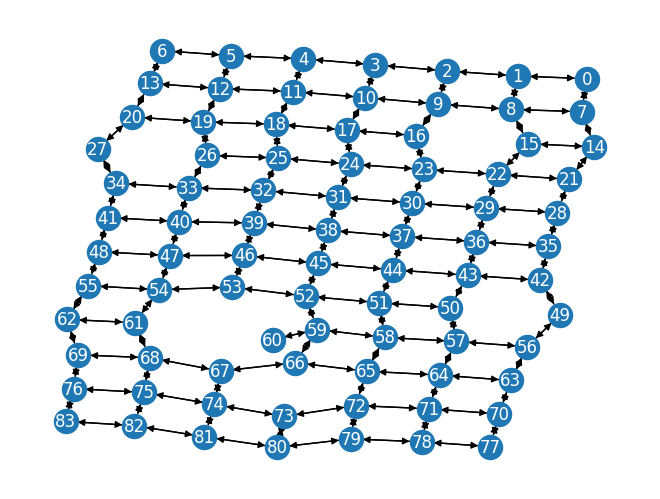

In [32]:
import networkx as nx
# access and visualize the device topology
print(rigetti.properties.paradigm.connectivity.connectivityGraph)
nx.draw_kamada_kawai(rigetti.topology_graph, with_labels=True, font_color="white")

Now we can submit a quantum task of the above program with verbatim box.

In [33]:
verbatim_task = rigetti.run(OpenQASMProgram(source=program_with_verbatim_box), shots = 10)
verbatim_result = verbatim_task.result()
meta = verbatim_result.additional_metadata.rigettiMetadata
print(meta.compiledProgram)

PRAGMA INITIAL_REWIRING "NAIVE"
DECLARE ro BIT[2]
PRAGMA PRESERVE_BLOCK
RX(3.141592653589793) 0
RX(3.141592653589793) 0
ISWAP 0 1
PRAGMA END_PRESERVE_BLOCK
MEASURE 0 ro[0]
MEASURE 1 ro[1]


As shown above, the two consecutive `rx`  $\pi$-rotation gates did not get optimized and we confirm that our program was indeed executed verbatim.

## Requesting Result Types with OpenQASM

Braket provides [a rich library of result types](https://docs.aws.amazon.com/braket/latest/developerguide/braket-result-types.html) for circuit executions. With OpenQASM, requesting different result types for our quantum tasks is easier than ever using the `result` pragma. Next, we give an example of requesting result types for our Bell state program submitted to SV1. Before doing that, let's see what result types are supported on SV1:

In [34]:
# print the result types supported by SV1
for iter in sv1.properties.action['braket.ir.openqasm.program'].supportedResultTypes:
    print(iter)

name='Sample' observables=['x', 'y', 'z', 'h', 'i', 'hermitian'] minShots=1 maxShots=100000
name='Expectation' observables=['x', 'y', 'z', 'h', 'i', 'hermitian'] minShots=0 maxShots=100000
name='Variance' observables=['x', 'y', 'z', 'h', 'i', 'hermitian'] minShots=0 maxShots=100000
name='Probability' observables=None minShots=1 maxShots=100000
name='Amplitude' observables=None minShots=0 maxShots=0
name='AdjointGradient' observables=['x', 'y', 'z', 'h', 'i'] minShots=0 maxShots=0


With knowing the supported result types on SV1, we choose to request the `Expectation` of $X \otimes Z$ observable on `q[0]` and `q[1]` and the `Amplitude` result type for a `shots=0` quantum task of our bell program:

In [35]:
bell_with_result_type = """
OPENQASM 3;

qubit[2] q;

#pragma braket result expectation x(q[0]) @ z(q[1])
#pragma braket result amplitude "00", "11"
h q[0];
cnot q[0], q[1];
"""

The location of the `result` pragma is very flexible as long as it's after the qubit register definition (if you use physical qubits, you can put `result` pragmas anywhere after the program header).

We can submit the above program and receive the results for our requested result types.

In [36]:
bell_result_types_task = sv1.run(OpenQASMProgram(source=bell_with_result_type), shots = 0)
bell_result = bell_result_types_task.result()
values = bell_result.values
print(values)

[0.0, {'00': (0.7071067811865475+0j), '11': (0.7071067811865475+0j)}]


At last, we want to remind our Braket OpenQASM users that there are two requirements when requesting result types:
1. For `shots=0` quantum tasks, requesting non-simultaneously measurable result types is allowed, but for `shots>0` quantum tasks, it is not allowed. For example, we can write the following OpenQASM program in a `shots=0` quantum task but not in a `shots>0` quantum task, since the two result types are not simultaneously measurable:

In [37]:
program_with_non_simultaneously_measurable_result_types = """
OPENQASM 3;

qubit[2] q;

h q[0];
cnot q[0], q[1];

#pragma braket result expectation x(q[0]) @ z(q[1])
#pragma braket result expectation hermitian([[0, -1im], [1im, 0]]) q[0]
"""

2. Do not use measurement instructions and request result types in the same OpenQASM program, otherwise a validation error will be raised. Since measurement instructions are basically equivalent to `#pragma braket result sample z(qubit)`, we encourage users to adapt a consistent style of requesting result types in the same program.

Circuits constructed with `from_ir` will have the correct result types:

In [38]:
print("bell_with_result_type:")
print(Circuit.from_ir(bell_with_result_type))

bell_with_result_type:
T  : │  0  │  1  │    Result Types    │
      ┌───┐       ┌──────────────────┐ 
q0 : ─┤ H ├───●───┤ Expectation(X@Z) ├─
      └───┘   │   └────────┬─────────┘ 
            ┌─┴─┐ ┌────────┴─────────┐ 
q1 : ───────┤ X ├─┤ Expectation(X@Z) ├─
            └───┘ └──────────────────┘ 
T  : │  0  │  1  │    Result Types    │

Additional result types: Amplitude(00,11)


## Advanced OpenQASM features

OpenQASM has features beyond what is natively supported by the `Circuit` class. You can run OpenQASM tasks directly on the Local Simulator or use Circuit.from_ir to convert an OpenQASM program to a Circuit object, which is supported by all circuit-based Braket devices. The following OpenQASM program is a GHZ state written with classical control flow and subroutines:


In [39]:
ghz_with_advanced_features = """
OPENQASM 3.0;

def ghz(int[32] n) {
    h q[0];
    for int i in [0:n - 1] {
        cnot q[i], q[i + 1];
    }
}

int[32] n = 5;
bit[n + 1] c;
qubit[n + 1] q;

ghz(n);

c = measure q;
"""
qasm_program = OpenQASMProgram(source=ghz_with_advanced_features)

The local simulator supports these features:

In [40]:
from braket.devices import LocalSimulator
LocalSimulator().run(qasm_program, shots=1000).result().measurement_counts

This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


Counter({'000000': 505, '111111': 495})

but SV1 does not. However, `from_ir` will "unroll" the subroutine and loop to create a `Circuit` object that _can_ run on SV1:

In [41]:
circuit = Circuit.from_ir(qasm_program)
print(circuit)
print(sv1.run(circuit, shots=1000).result().measurement_counts)

This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │
      ┌───┐                               ┌───┐ 
q0 : ─┤ H ├───●───────────────────────────┤ M ├─
      └───┘   │                           └───┘ 
            ┌─┴─┐                         ┌───┐ 
q1 : ───────┤ X ├───●─────────────────────┤ M ├─
            └───┘   │                     └───┘ 
                  ┌─┴─┐                   ┌───┐ 
q2 : ─────────────┤ X ├───●───────────────┤ M ├─
                  └───┘   │               └───┘ 
                        ┌─┴─┐             ┌───┐ 
q3 : ───────────────────┤ X ├───●─────────┤ M ├─
                        └───┘   │         └───┘ 
                              ┌─┴─┐       ┌───┐ 
q4 : ─────────────────────────┤ X ├───●───┤ M ├─
                              └───┘   │   └───┘ 
                                    ┌─┴─┐ ┌───┐ 
q5 : ───────────────────────────────┤ X ├─┤ M ├─
                                    └───┘ └───┘ 
T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │
Counter({'000000': 5

For an in-depth exploration of advanced OpenQASM features, see [Simulating Advanced OpenQASM Programs with the Local Simulator](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/braket_features/Simulating_Advanced_OpenQASM_Programs_with_the_Local_Simulator.ipynb).

# Conclusion

In this notebook, you learned how to submit OpenQASM quantum tasks and use OpenQASM features on Braket. Hope you enjoyed it! You can find more information about OpenQASM3.0 in its [live specification](https://openqasm.com/), and you can learn more about OpenQASM support on Braket in the [Amazon Braket documentation](https://docs.aws.amazon.com/braket/latest/developerguide/).

In [42]:
print("Quantum Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD")

Quantum Task Summary
{<_Amazon.SV1: 'arn:aws:braket:::device/quantum-simulator/amazon/sv1'>: {'shots': 1120, 'tasks': {'CREATED': 1, 'COMPLETED': 4}, 'execution_duration': datetime.timedelta(microseconds=104000), 'billed_execution_duration': datetime.timedelta(seconds=12)}, <_Amazon.DM1: 'arn:aws:braket:::device/quantum-simulator/amazon/dm1'>: {'shots': 30, 'tasks': {'COMPLETED': 3}, 'execution_duration': datetime.timedelta(microseconds=39000), 'billed_execution_duration': datetime.timedelta(seconds=9)}, <_Rigetti.Ankaa2: 'arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-2'>: {'shots': 20, 'tasks': {'COMPLETED': 2}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Esti